## Imports and inital setup

In [322]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
import random
import string
import sys

SEED = 42
MAX_SAMPLES = 3000
NUM_CLASSES = 7
NUM_EPOCHS = 2

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/processed/Metadata_processed.csv"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
TARGET_LABEL="dx_binary"

### Delets all augmented images in advance

In [323]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/"  # Replace with your folder path

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


In [324]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0031633.jpg


## Splitting the data in train, validation and test sets

In [325]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata[TARGET_LABEL], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[TARGET_LABEL], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 10)

(2003, 10)

(2003, 10)

## Tackling Class imbalances in the training set

### Setting up the image data generators

In [326]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    #rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
    rotation_range=40,   # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the width by up to 20%
    height_shift_range=0.2, # Randomly shift the height by up to 20%
    shear_range=0.2,     # Apply shear transformations
    zoom_range=0.2,      # Apply zoom transformations
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Create an ImageDataGenerator for validation data (no augmentation)

datagen_validation = ImageDataGenerator(
    #rescale=1.0 / 255.0 #see above
)


### Helper Function: Load images from directory and return as numpy array

In [327]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Load the image using PIL
    image = Image.open(image_path)
    
    # Resize the image to the target size
    image = image.resize(target_size)
    
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)
    
    # Perform any additional preprocessing steps here
    # For example, you can normalize pixel values to [0, 1]
    # image_array = image_array / 255.0
    
    return image_array

In [328]:
# Define a function to generate a random string for image ID prefixes
def generate_random_string(length=6):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

In [329]:
# Create separate DataFrames for each class 

class_dataframes = {}
for class_label in train_df[TARGET_LABEL].unique():
    class_dataframes[class_label] = train_df[train_df[TARGET_LABEL] == class_label]
    print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")
    #display(class_dataframes[class_label].head())

Class not_skin_cancer has 4837 samples
Class skin_cancer has 1172 samples


In [330]:
# Initialize a dictionary to keep track of the number of augmented images per class
class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

# Create a list to store DataFrames for each class
augmented_dataframes = []

# Apply data augmentation for classes with few examples, trim classes with too many examples
for class_label, class_df in class_dataframes.items():
    
    # Describing the overall progress
    print(f"\nChecking class {class_label}...")

    # Check if the class has already reached the maximum number of augmented images // TO BE DELETED
    #if class_augmentation_counts[class_label] >= MAX_SAMPLES:
    #    continue

    # Calculate the number of images needed to reach MAX_SAMPLES for this class
    images_needed = MAX_SAMPLES - class_df.shape[0]
    
    # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
    if images_needed < 0:
        print(f"> Result: Class {class_label} was reduced to {MAX_SAMPLES} samples")
        reduced_df = class_df.sample(n=MAX_SAMPLES, random_state=SEED)
        augmented_dataframes.append(reduced_df)
        continue
    # If images_needed is zero, skip this class
    elif images_needed == 0:
        print(f"> Result: Class {class_label} already has exactly {MAX_SAMPLES} samples")
        augmented_dataframes.append(class_df)
        continue

    # Generate augmented data - this part only runs if images_needed is positive
    print(f"> Result: Class {class_label} needs {images_needed} more images")
    augmented_dataframes.append(class_df)

    while class_augmentation_counts[class_label] <= images_needed:

        # Describing the subprocess progress for each class
        sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
        sys.stdout.flush()

        # Randomly select an image from the class_df
        i = random.randint(0, class_df.shape[0] - 1)
        image_path = class_df.iloc[i]['image_path']

        # Load and preprocess the image
        img = load_and_preprocess_image(image_path)

        # Apply data augmentation via generator
        augmented_img = datagen_train.random_transform(img)

        # Create a new image ID with prefix
        augmented_image_id = f'aug_{generate_random_string()}' + os.path.basename(image_path)

        # Create a new image path with the augmented image ID as string
        augmented_image_path = FILEPATH_JPGS + augmented_image_id
        
        # Create a new DataFrame for the augmented data for this instance only
        augmented_instance_df = class_df.iloc[i:i+1].copy()
        
        # Reset the index of the new DataFrame
        augmented_instance_df.reset_index(drop=True, inplace=True)

        # Update the "image_id" column with the augmented image ID
        augmented_instance_df.at[0, 'image_id'] = augmented_image_id
        
        # Update the "image_path" column with the augmented image path
        augmented_instance_df.at[0, 'image_path'] = augmented_image_path
        
        # Append the augmented DataFrame for this instance to the list
        augmented_dataframes.append(augmented_instance_df)

        # Save the augmented image to the output folder
        augmented_image_path = os.path.join(FILEPATH_OUTPUT, augmented_image_id)
        plt.imsave(augmented_image_path, augmented_img)

        # Update the counter for the class
        class_augmentation_counts[class_label] += 1

        #if class_augmentation_counts[class_label] > 18:
        #    break

# Combine all augmented DataFrames into a single DataFrame
balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

balanced_train_df.shape



Checking class not_skin_cancer...
> Result: Class not_skin_cancer was reduced to 3000 samples

Checking class skin_cancer...
> Result: Class skin_cancer needs 1828 more images
Progress: 1828/1828

(6001, 10)

In [331]:
# counting the number of samples per class
balanced_train_df[TARGET_LABEL].value_counts()

dx_binary
skin_cancer        3001
not_skin_cancer    3000
Name: count, dtype: int64

In [332]:
# Checking what's going on in the foleder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 11844
Files starting with 'aug_': 1829


In [333]:
balanced_train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
5555,HAM_0001424,aug_KvHEfYISIC_0031470.jpg,bcc,histo,65.0,female,back,rosendahl,skin_cancer,./../data/jpgs/aug_KvHEfYISIC_0031470.jpg
3640,HAM_0001950,ISIC_0024449.jpg,mel,histo,55.0,male,back,vienna_dias,skin_cancer,./../data/jpgs/ISIC_0024449.jpg
1907,HAM_0003722,ISIC_0030052.jpg,nv,follow_up,40.0,male,abdomen,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0030052.jpg
568,HAM_0002892,ISIC_0032469.jpg,nv,follow_up,30.0,male,back,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0032469.jpg
2715,HAM_0002762,ISIC_0029458.jpg,nv,follow_up,45.0,male,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0029458.jpg
1584,HAM_0003413,ISIC_0030969.jpg,nv,follow_up,40.0,male,upper extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0030969.jpg
621,HAM_0005083,ISIC_0033516.jpg,nv,histo,55.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0033516.jpg
2907,HAM_0000102,ISIC_0032221.jpg,nv,consensus,20.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0032221.jpg
3621,HAM_0007047,ISIC_0025605.jpg,akiec,histo,60.0,female,lower extremity,rosendahl,skin_cancer,./../data/jpgs/ISIC_0025605.jpg
3055,HAM_0004592,ISIC_0029141.jpg,akiec,histo,60.0,female,face,rosendahl,skin_cancer,./../data/jpgs/ISIC_0029141.jpg


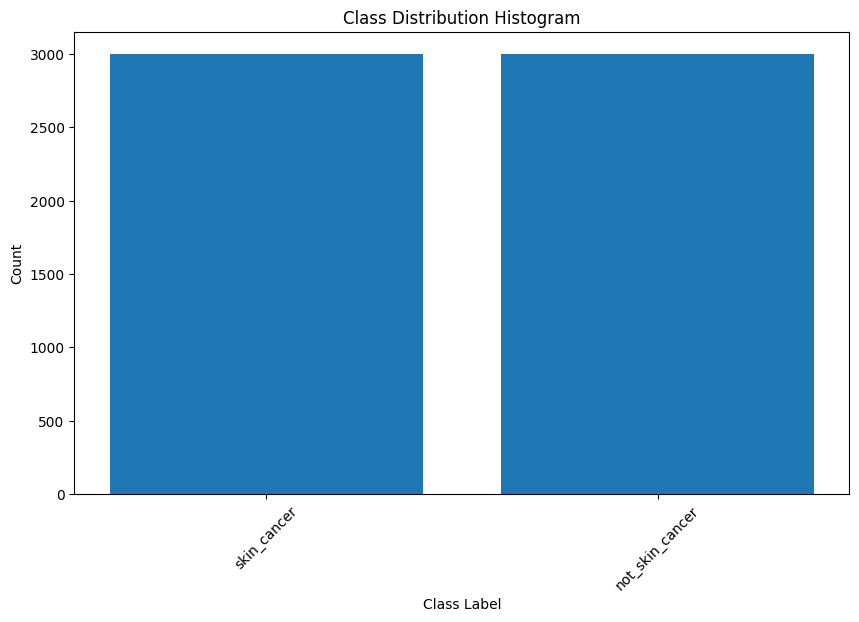

In [334]:
# Count the occurrences of each class in the DataFrame
class_counts = balanced_train_df[TARGET_LABEL].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution Histogram')
plt.xticks(rotation=45)
plt.show()

In [335]:
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    #subset="validation",
    class_mode="categorical",
    target_size=(128, 128),
    batch_size=32
)

Found 2003 validated image filenames belonging to 2 classes.


"Found 2003 validated image filenames belonging to 7 classes."
--> validated means, that the image is in the right format and can be loaded by the model from the directory and matched with an entry in the csv file

## Adding an neural network model to test the data

In [338]:
# Define super basic neural network architecture
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),

    # Convolutional block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flattening the output of the convolutional layers
    tf.keras.layers.Flatten(),

    # Dense (fully connected) layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(balanced_train_df[TARGET_LABEL].nunique(), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 128)     

In [339]:
# Train the model

history = model.fit(
    datagen_train.flow_from_dataframe(
        dataframe=balanced_train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=(128, 128),
        batch_size=32
    ),
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    verbose=1  # Adjust verbosity level
)

Found 6001 validated image filenames belonging to 2 classes.
Epoch 1/2
188/188 [==============================] - 52s 276ms/step - loss: 11.2518 - accuracy: 0.6117 - val_loss: 0.5455 - val_accuracy: 0.5647
Epoch 2/2
188/188 [==============================] - 57s 301ms/step - loss: 0.6021 - accuracy: 0.6712 - val_loss: 0.5436 - val_accuracy: 0.5856
